In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [160]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.energy_consumption import Energy2011
from src.Constants import Constants
sns.set_theme(style="ticks")
import numpy as np

# 1. Energy consumption in buildings

In [224]:
trans = pd.read_csv('../data/privatna_vozila_2011.csv')
heat = pd.read_csv('../data/vinkovci_grijanje_2011.csv')
ele = pd.read_csv('../data/vinkovci_struja_2011.csv')

In [38]:
charts = Energy2011()

In [226]:
heat['potrošnja_energije(MWh)'] = heat['potrošnja_energije(kWh)'] / 1000

In [227]:
tablica_1 = heat.pivot_table(
    index=['nadkategorija', 'kategorija', 'broj zgrada', 'ukupna_grijana_površina', 
           'specifična_potrošnja_energije(kWh/m2)'],
    columns='energent', 
    values='potrošnja_energije(MWh)',
    aggfunc='sum',
    fill_value=0
).groupby('kategorija').sum()

In [228]:
tablica_1

energent,električna energija,lož ulje,ogrjevno drvo,prirodni plin
kategorija,,,,
komercijalne i uslužne djelatnosti,2340.448,6441.28200,23188.61520,62307.56056
kulturne ustanove,0.000,63.25826,0.00000,657.67756
objekti i uredi gradskih tvrtki,0.000,0.00000,0.00000,473.13697
stambeni sektor,15646.120,5760.00351,41250.80853,85563.07134
uprava,37.800,0.00000,0.00000,593.80058
školstvo,0.000,15.30442,0.00000,3219.44426


/home/dionizije/Documents/vk_secap/src/energy_consumption.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chart = plt.pie(


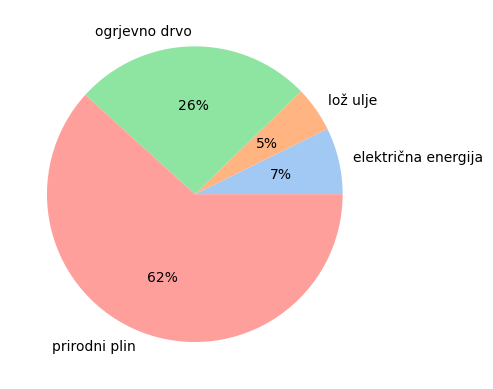

In [49]:
toplina_izvor = charts.heat_by_source()
toplina_sektor = charts.energy_by_sector('heat')
struja_sektor = charts.energy_by_sector('electricity')
gas_by_type = charts.gas_by_type()
gas_by_category = charts.gas_by_category()
illumination = charts.illumination()

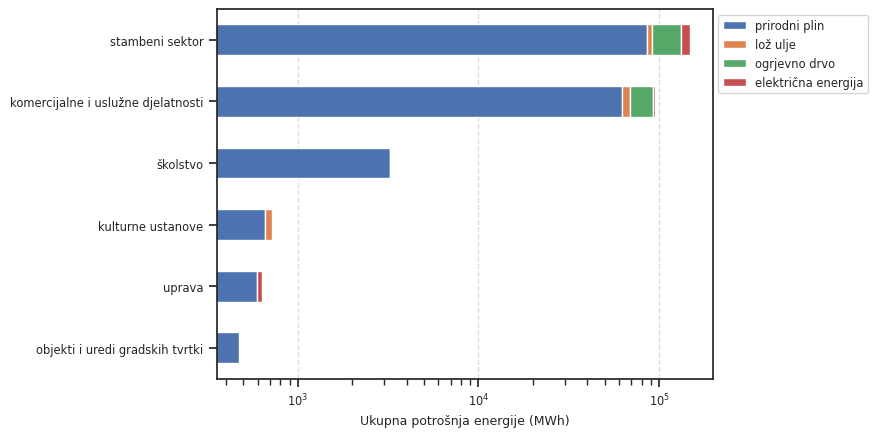

In [232]:
df_pivot = heat.pivot(index='kategorija', columns='energent', values='potrošnja_energije(MWh)').fillna(0)
order = ['prirodni plin', 'lož ulje', 'ogrjevno drvo', 'električna energija']
df_pivot = df_pivot[order]
df_pivot['Total'] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values(by='Total', ascending=True).drop(columns=['Total'])


# Plot
fig, ax = plt.subplots()
df_pivot.plot(kind='barh', stacked=True, ax=ax, width=0.5)
threshold = 50000  # adjust this threshold as needed
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Reduce font size for axis labels
plt.rc('axes', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Set x-label and remove y-label
ax.set_xlabel("Ukupna potrošnja energije (MWh)", fontsize=9)
ax.set_ylabel("")
ax.set_xscale('log')

# Adjust legend
legend = ax.legend(fontsize='x-small', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='x-small')

# Layout adjustment for accommodating the legend outside the plot

plt.show()